### Clone repository, download models and data, install necessary packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone -q https://github.com/tanguy-magne/ritm_interactive_segmentation

# Evaluation datasets are stored in another repository
URL_PREFIX_FBRS = "https://github.com/saic-vul/fbrs_interactive_segmentation/releases/download/v1.0"
URL_PREFIX_RITM = "https://github.com/saic-vul/ritm_interactive_segmentation/releases/download/v1.0"
DATA_FOLDER = "./ritm_interactive_segmentation/datasets" 
WEIGHTS_FOLDER = "./ritm_interactive_segmentation/weights"

!mkdir -p {DATA_FOLDER}
!mkdir -p {WEIGHTS_FOLDER}

# CHOOSE MODEL HERE
# possible choices are: coco_lvis_h18s_itermask,  coco_lvis_h18_baseline, coco_lvis_h18_itermask,
# coco_lvis_h18_itermask, sbd_h18_itermask
MODEL_NAME = "coco_lvis_h18s_itermask"
WEIGHTS_URL = f"{URL_PREFIX_RITM}/{MODEL_NAME}.pth"
!wget -q -P {WEIGHTS_FOLDER} {WEIGHTS_URL}

#for dataset in ['GrabCut', 'Berkeley', 'DAVIS', 'COCO_MVal']:
#  dataset_url = f"{URL_PREFIX_FBRS}/{dataset}.zip"
#  dataset_path = f"{DATA_FOLDER}/{dataset}.zip"
#  !wget -q -O {dataset_path} {dataset_url}
#  !unzip -q {dataset_path} -d {DATA_FOLDER}
#  !rm {dataset_path}

IM_SAT_DATASET = '/content/drive/MyDrive/MVA/2.1.SatelliteIImage/Projet/data/'

for dataset in ['IM_SAT_TRAIN', 'IM_SAT_VAL_SMALL', 'IM_SAT_VAL']:   # IM_SAT_VAL IM_SAT_TRAIN
  dataset_path = f"{IM_SAT_DATASET}/{dataset}.zip"
  !unzip -q {dataset_path} -d {DATA_FOLDER}

!pip3 install -q -r ./ritm_interactive_segmentation/requirements.txt
%cd ritm_interactive_segmentation/

     |████████████████████████████████| 47.8 MB 48 kB/s 
     |████████████████████████████████| 948 kB 44.9 MB/s 
     |████████████████████████████████| 102 kB 33.7 MB/s 
     |████████████████████████████████| 108 kB 41.2 MB/s 
/content/ritm_interactive_segmentation


### Imports

In [3]:
!pip install opencv-python-headless==4.1.2.30
!pip install albumentations==0.5.1
import albumentations
albumentations.__version__

     |████████████████████████████████| 21.8 MB 5.3 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.64
    Uninstalling opencv-python-headless-4.5.5.64:
      Successfully uninstalled opencv-python-headless-4.5.5.64
     |████████████████████████████████| 71 kB 123 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.1.0
    Uninstalling albumentations-1.1.0:
      Successfully uninstalled albumentations-1.1.0


'0.5.1'

In [4]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import glob
import sys
import torch
import numpy as np

sys.path.insert(0, './')

from isegm.utils import vis, exp
from isegm.inference import utils
from isegm.inference.evaluation import evaluate_dataset, evaluate_sample

device = torch.device('cuda:0')
cfg = exp.load_config_file('./config.yml', return_edict=True)


### Init dataset

In [13]:
# Possible choices: 'GrabCut', 'Berkeley', 'DAVIS', 'COCO_MVal', 'IM_SAT_VAL_SMALL'
DATASET = 'IM_SAT_VAL_SMALL'
is_IM_SAT = DATASET in ['IM_SAT_VAL_SMALL', 'IM_SAT_VAL', 'IM_SAT_TRAIN']
dataset = utils.get_dataset(DATASET, cfg)

In [19]:
MODEL_NAME = "finetune" # or "finetune" "train_from_scratch" "coco_lvis_h18s_itermask"
MODEL_NAME

'finetune'

### Init model

In [15]:
from isegm.inference.predictors import get_predictor

EVAL_MAX_CLICKS = 20
MODEL_THRESH = 0.49

checkpoint_path = utils.find_checkpoint(cfg.INTERACTIVE_MODELS_PATH, MODEL_NAME)
model = utils.load_is_model(checkpoint_path, device)

# Possible choices: 'NoBRS', 'f-BRS-A', 'f-BRS-B', 'f-BRS-C', 'RGB-BRS', 'DistMap-BRS'
brs_mode = 'NoBRS'
predictor = get_predictor(model, brs_mode, device, prob_thresh=MODEL_THRESH)

### Dataset evaluation

In [ ]:
TARGET_IOU = 1.1 #0.9

all_ious, elapsed_time = evaluate_dataset(dataset, predictor, pred_thr=MODEL_THRESH, 
                                          max_iou_thr=TARGET_IOU, max_clicks=EVAL_MAX_CLICKS)
mean_spc, mean_spi = utils.get_time_metrics(all_ious, elapsed_time)
noc_list, over_max_list = utils.compute_noc_metric(all_ious,
                                                   iou_thrs=[0.8, 0.85, 0.9],
                                                   max_clicks=EVAL_MAX_CLICKS)

header, table_row = utils.get_results_table(noc_list, over_max_list, brs_mode, DATASET,
                                            mean_spc, elapsed_time, EVAL_MAX_CLICKS)
print(header)
print(table_row)



  0%|          | 0/2500 [00:00<?, ?it/s]

./isegm/inference/utils.py:80: RuntimeWarning: invalid value encountered in long_scalars
  return intersection / union


---------------------------------------------------------------------------------------------------------------
|  BRS Type   |     Dataset     | NoC@80% | NoC@85% | NoC@90% |>=20@80% |>=20@85% |>=20@90% | SPC,s |  Time   |
---------------------------------------------------------------------------------------------------------------
|    NoBRS    |   IM_SAT_VAL    |  16.22  |  17.38  |  18.60  |  0.648  |  0.745  |  0.853  | 0.039 | 0:32:10 |


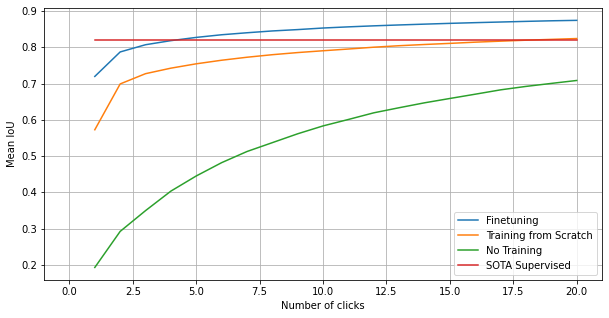

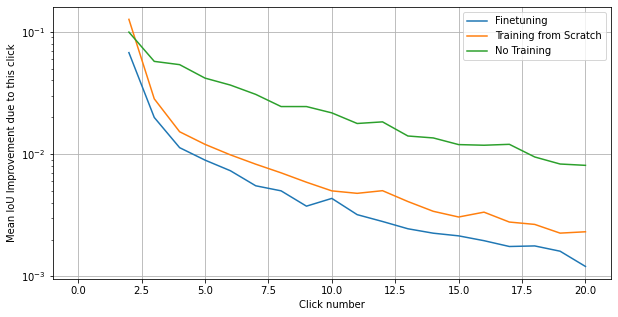

In [16]:
all_ious_finetune = np.load('./notebooks/all_ious_finetune.npy')
means_finetune = np.nanmean(all_ious_finetune, axis=0)
all_ious_scratch = np.load('./notebooks/all_ious_scratch.npy')
means_scratch = np.nanmean(all_ious_scratch, axis=0)
all_ious_notrain = np.load('./notebooks/all_ious_notrain.npy')
means_notrain = np.nanmean(all_ious_notrain, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(EVAL_MAX_CLICKS) + 1, means_finetune, label='Finetuning')
plt.plot(np.arange(EVAL_MAX_CLICKS) + 1, means_scratch, label='Training from Scratch')
plt.plot(np.arange(EVAL_MAX_CLICKS) + 1, means_notrain, label='No Training')
plt.plot([1, 20], [0.82, 0.82], label="SOTA Supervised")
plt.xlabel("Number of clicks")
plt.ylabel("Mean IoU")
plt.xlim(-1, 21)
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(np.arange(EVAL_MAX_CLICKS - 1) + 2, means_finetune[1:] - means_finetune[:-1], label='Finetuning')
plt.plot(np.arange(EVAL_MAX_CLICKS - 1) + 2, means_scratch[1:] - means_scratch[:-1], label='Training from Scratch')
plt.plot(np.arange(EVAL_MAX_CLICKS - 1) + 2, means_notrain[1:] - means_notrain[:-1], label='No Training')
plt.xlabel("Click number")
plt.xlim(-1, 21)
plt.ylabel("Mean IoU Improvement due to this click")
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

# plt.figure(figsize=(10, 5))
# plt.plot(np.arange(EVAL_MAX_CLICKS) + 1, samples)
# plt.xlabel("Number of clicks")
# plt.ylabel("Number of sample remaining")
# plt.show()

In [ ]:
print(f"The average IoU after 20 clicks maximum is {np.nanmean(all_ious[:,-1]):.3f}, with a standard deviation of {np.nanstd(all_ious[:,-1]):.3f}. -- Taking the last score")
print(f"The average IoU after 20 clicks maximum is {np.nanmean(np.max(all_ious, axis=1)):.3f}, with a standard deviation of {np.nanstd(np.max(all_ious, axis=1)):.3f}. -- Taking the best score")

The average IoU after 20 clicks maximum is 0.709, with a standard deviation of 0.173. -- Taking the last score
The average IoU after 20 clicks maximum is 0.718, with a standard deviation of 0.166. -- Taking the best score


### Single sample eval

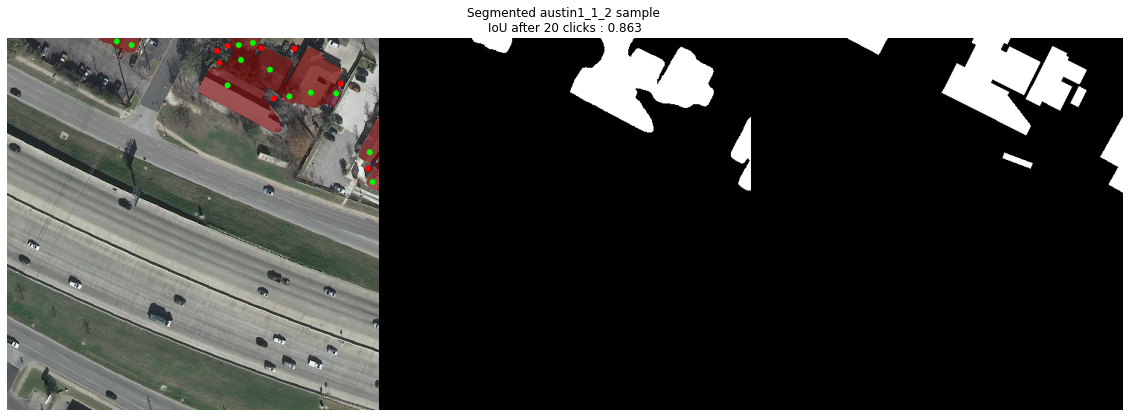

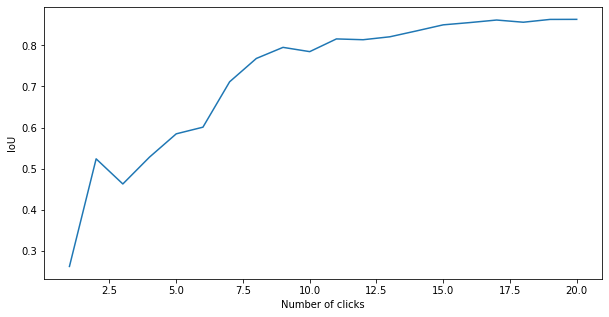

In [20]:
sample_id = 12   # 12, 100, 101, 226, 325, 400
TARGET_IOU = 0.95

sample = dataset.get_sample(sample_id)
gt_mask = sample.gt_mask

clicks_list, ious_arr, pred = evaluate_sample(sample.image, gt_mask, predictor, 
                                              pred_thr=MODEL_THRESH, 
                                              max_iou_thr=TARGET_IOU, max_clicks=EVAL_MAX_CLICKS) #EVAL_MAX_CLICKS

pred_mask = pred > MODEL_THRESH
draw = vis.draw_with_blend_and_clicks(sample.image, mask=pred_mask, clicks_list=clicks_list)
draw = np.concatenate((draw,
    255 * pred_mask[:, :, np.newaxis].repeat(3, axis=2),
    255 * (gt_mask > 0)[:, :, np.newaxis].repeat(3, axis=2)
), axis=1)

if is_IM_SAT:
  all = np.sort(glob.glob(f"/content/ritm_interactive_segmentation/datasets/{DATASET}/gt/*.png"))
  sample_name = all[sample_id].split('/')[-1].split('.')[0]

plt.figure(figsize=(20, 30))
plt.imshow(draw)
if is_IM_SAT:
  plt.title(f"Segmented {sample_name} sample \nIoU after {len(ious_arr)} clicks : {ious_arr[-1]:.3f}")
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(np.arange(ious_arr.shape[0]) + 1, ious_arr)
plt.xlabel("Number of clicks")
plt.ylabel("IoU")
plt.show()

# TRAINING ON SAT IMAGES

In [ ]:
!python3 train.py models/iter_mask/train_sat_img.py --gpus=0 --workers=6 --exp-name=finetune2

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Epoch 51, training loss 0.2829:  99%|############################8| 355/357 [07:53<00:02,  1.26s/it]
Save checkpoint to experiments/iter_mask/sat_hrnet18/000_finetune2/checkpoints/last_checkpoint.pth
Epoch 52, training loss 0.2861:  99%|############################6| 353/357 [07:39<00:05,  1.42s/it]
Save checkpoint to experiments/iter_mask/sat_hrnet18/000_finetune2/checkpoints/last_checkpoint.pth
Epoch 53, training loss 0.2828: 100%|############################9| 356/357 [07:45<00:01,  1.29s/it]
Save checkpoint to experiments/iter_mask/sat_hrnet18/000_finetune2/checkpoints/last_checkpoint.pth
Epoch 54, training loss 0.2874:  99%|############################7| 354/357 [07:42<00:03,  1.21s/it]
Save checkpoint to experiments/iter_mask/sat_hrnet18/000_finetune2/checkpoints/last_checkpoint.pth
Epoch 55, training loss 0.2840:  99%|############################7| 354/357 [07:37<00:04,  1.46s/it]
Save checkpoint to ex